In [1]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import torch

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from numpy.lib.stride_tricks import sliding_window_view
from models.last_layer_models import LLI, train_last_layer_det
from models.gibbs_sampler import get_pred_post_dist
from models.vi import fit_vi_post_hoc, fit_vi_post_hoc
from models.gibbs_sampler import get_pred_post_dist
from torch.distributions import Normal
from utils.data_utils import create_synthetic_train_data

np.random.seed(100)

Text(0.5, 1.0, 'Training/Validation split')

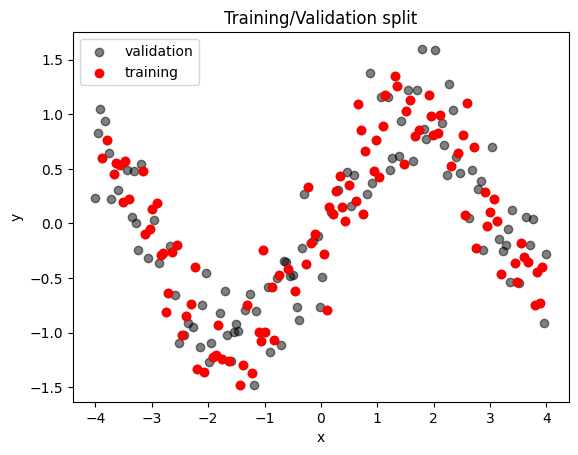

In [2]:
xs, ys, xs_train, ys_train, xs_val, ys_val = create_synthetic_train_data(xs_range = [-4,4], num_points = 200,  sigma_eps = 0.3)

# visualize train/val split
fig, axs = plt.subplots(1,1)
axs.scatter(xs, ys, c = 'black', label = 'validation', alpha =.5)
axs.scatter(xs_train, ys_train, c = 'red', label = 'training', alpha = 1)
axs.legend()
axs.set_xlabel('x')
axs.set_ylabel('y')
axs.set_title("Training/Validation split")

In [5]:
data = TensorDataset(xs_train, ys_train)
train_set, val_set = torch.utils.data.random_split(data, [80, 20])
dataloader_train = DataLoader(train_set, shuffle = True, batch_size=5)
dataloader_val = DataLoader(val_set, shuffle = True, batch_size=20)

# all models have 4 layers with 100, 100, 5 and 1 neuron(s), respectively.
model_dims = [1, 100, 100, 100, 50, 1]
num_epochs = 100
lli_net = LLI(model_dims)
sigma_0 = 0.3

100%|██████████| 100/100 [00:00<00:00, 159.49it/s]


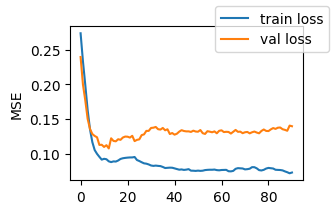

In [6]:
# train deep feature projector psi
lli_net, losses_train, losses_val = train_last_layer_det(model = lli_net, 
                                                         dataloader_train = dataloader_train,
                                                         dataloader_val = dataloader_val, 
                                                         num_epochs = num_epochs)

lli_net.eval()

# plot losses
fig, axs = plt.subplots(1,1, figsize = (3,2))
axs.plot(sliding_window_view(np.array(losses_train), 10).mean(axis=1), label = 'train loss')
axs.plot(sliding_window_view(np.array(losses_val), 10).mean(axis=1), label = 'val loss')
axs.set_ylabel('MSE')
fig.legend()

## VI

For the ridge prior we have an $(L + 2)$-dimensional variational distribution.
We have $L$ dimensions for $w_1, \ldots, w_L$ and 2 more for $\log(\tau^2)$ and $\log(\sigma_{\varepsilon}^2)$. 

For VI, we iterate the following steps:

1. Draw $w^{(t)}, \log(\tau^2)^{(t)}, \log(\sigma_{\varepsilon}^{(t)})$ by generating noise $\zeta^{(t)} \sim \mathcal{N}(0, I)$ and computing $\mu + \sigma \zeta$.
2. Transform $\log(\tau^2)^{(t)}, \log(\sigma_{\varepsilon}^{(t)}$ back to $\tau^2, \sigma_{\varepsilon}$ by exponentiating.
3. Compute the ELBO objective: $h(\vartheta) - q_{\lambda}(\vartheta)$ where $h(\vartheta)= p(y | x, w, \sigma_{\varepsilon}^2) \cdot p(w | \tau^2) \cdot p(\tau^2) \cdot p(\sigma_{\varepsilon}^2)$.
4. Compute gradients of the ELBO w.r.t the variational parameters.
5. Update the variational parameters in the direction of the gradients.

In [7]:
# fit last-layer posterior
Psi = lli_net.get_ll_embedd(xs_train)

lambdas, elbos, mus, rhos = fit_vi_post_hoc(ys = ys_train.detach(), Psi = Psi.detach(), 
                lr = 1e-3, num_iter = 5000, 
                method = 'ridge')

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:08<00:00, 610.39it/s]


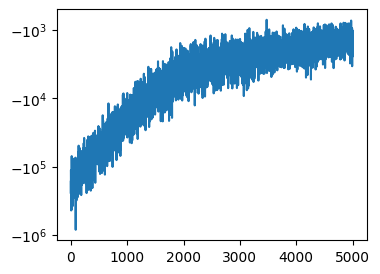

In [8]:
fig, axs = plt.subplots(1,1, figsize = (4,3))
axs.plot(np.array(elbos))
axs.set_yscale('symlog', base=10)

In [9]:
preds = {'mean': [],
         'var': []}

xs_pred_np = np.linspace(-10,10,200)
xs_pred = torch.tensor(xs_pred_np).unsqueeze(-1).float()

Psi_pred = lli_net.get_ll_embedd(xs_pred)
_, L = Psi_pred.shape

# Use the last 5% of all samples for the final parameters
# of the variational distribution:
final_mu = torch.stack(mus[int(.95*len(mus)):]).mean(dim = 0)
final_sigma = torch.exp(torch.stack(rhos[int(.95*len(rhos)):])).mean(dim = 0)

dist = Normal(loc = final_mu, scale = final_sigma)
samples = dist.rsample((1000,))
w_sample = samples[:, :L]
tau_sq_sample = torch.exp(samples[:, -2])
sigma_sq_sample = torch.exp(samples[:,-1])

In [11]:
# compute predictive densities, means and stds
ys_grid = torch.arange(-5,5, .01)
preds = {'mean': [], 'var': []}
for i in range(Psi_pred.shape[0]):
    pdf_vi_ridge , y_mean, y_var = get_pred_post_dist(Psi_pred[i], w_sample, sigma_sq_sample, ys_grid)
    preds['mean'].append(y_mean)
    preds['var'].append(y_var)
preds['mean'] = np.stack(preds['mean']).squeeze()
preds['std'] = np.sqrt(np.stack(preds['var'])).squeeze()

In [14]:
preds_fake = (Psi_pred @ final_mu [:L]).detach().numpy()

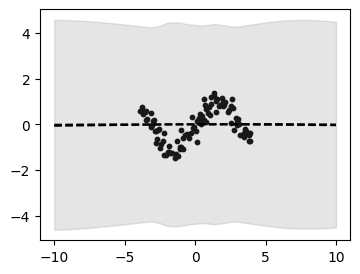

In [17]:
fig, axs = plt.subplots(1,1, figsize = (4,3))
axs.scatter(xs_train, ys_train, c = 'black', label = 'observed data', alpha = 1, s = 10)
axs.plot(xs_pred, preds_fake, c = 'black', linestyle = 'dashed', label = 'posterior mean')
axs.plot(xs_pred, preds['mean'], c = 'black', linestyle = 'dashed', label = 'posterior mean')
axs.fill_between(xs_pred.squeeze(),
                 preds['mean'] - 2*preds['std'],
                 preds['mean'] + 2*preds['std'],
                 alpha=0.2, color='gray', label='95% CI')

